Met Office AWS Earth data
=============

The Met Office has made data from its world leading weather models available for research purposes. In this page, we'll go over the basics of how to download the data, how you can look at it, and what it means.

Data from four models is available:

1. MOGREPS-UK: a high resolution ensemble weather forecast covering the UK.
1. MOGREPS-G: a global ensemble weather forecast.
1. UKV: a high resolution deterministic weather forecast covering the UK.
1. Global Atmospheric: a global deterministic weather forecast.

Amazon Web Services are kindly hosting this data for free as part of their Open Data Initiative.

## How is the data structured?
Our weather forecast models predict many weather parameters, such as air temperature, humidity or rainfall. These are predicted for every point on a regular grid, that is, as a function of latitude, longitude, and (when appropriate) altitude.

With the advent of our latest supercomputer, we now regularly run "ensemble forecasts". This means that instead of starting one model run now to predict tomorrow, we start many, purturbing the intial parameters to give several possible futures (or *realisations*). The spread of these different realisations gives an indication of the uncertainty of the forecast, and can be very powerful information.

![](http://data.informaticslab.co.uk/images/ensemble_forecasting_schematic.png)


Each forecast point also has several measures of time. Firstly, `time` indicates the real world time that the data is forecast for. Secondly, `reference_time` is the time that the forecast was started from i.e. the 0th `time` point. Finally, `forecast_period` is the difference between the two i.e. the number of hours that have elapsed since the start of the forecast.

## Downloading data
Here, we'll show you a simple way to download files using Python. The data is stored in AWS S3 buckets hosted in the eu-west-2 region. If that doesn't mean anything to you, don't worry - have a look at the Python functions below.

We also publish a notification to a SNS topic in AWS to alert new users that new data files are available. You can subscribe to these topics and filter your notifications by the data fields you are interest in. We will not cover SNS in this example so for now let's work with a sample notification which could've been published to a topic.

This message contains a data file which was generated with the Global MOGREPS model and contains air temperature at a range of altitudes over a spread of ensembles.

In [20]:
sample_sns_message = {
    'model': 'mo-atmospheric-mogreps-g-prd',
    'ttl': 1544268873,
    'time': '2018-12-13T09:00:00Z',
    'created_time': '2018-12-06T11:22:27Z',
    'name': 'air_temperature',
    'object_size': 711463962,
    'forecast_period': 615600,
    'forecast_reference_time': '2018-12-06T06:00:00Z',
    'pressure': '100000.0 97500.0 95000.0 92500.0 90000.0 85000.0 80000.0 75000.0 70000.0 65000.0 60000.0 55000.0 50000.0 45000.0 40000.0 37500.0 35000.0 32500.0 30000.0 27500.0 25000.0 22500.0 20000.0 17500.0 15000.0 12500.0 10000.0 7000.0 5000.0 4000.0 3000.0 2000.0 1000.0',
    'forecast_period_units': 'seconds',
    'pressure_units': 'Pa',
    'bucket': 'aws-earth-mo-examples',
    'key': 'cafef7005477edb001aa7dc50eab78c5ef89d420.nc',
    'realization': '0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34'
}

To ease downloading let's write a helper function which takes a notification and downloads the file into the current directory.

In [19]:
import urllib.request

def download_data_object(sns_message):
    url = "https://s3.eu-west-2.amazonaws.com/" + sns_message['bucket'] + "/" + sns_message['key']
    urllib.request.urlretrieve(url, sns_message['key']) # save in this directory with same name

Note that you can also use Python modules such as Boto to list, filter and retrieve these files.

We'll use this functions to download our sample object.

In [21]:
download_data_object(sample_sns_message)

and here is is.

In [60]:
!ls -ltrh {sample_sns_message['key']}

-rw-r--r-- 1 jovyan users 679M Dec  6 11:48 cafef7005477edb001aa7dc50eab78c5ef89d420.nc


## Loading Data

This data is in NetCDF format, which is a type of the widely used HDF format. You can use any compatible tools, but we recommend the Met Office's Iris Python module. First of all, let's make sure we've got Iris instaled using Conda.

In [ ]:
!conda install -y -c conda-forge iris

Now let's load the file we just downloaded

In [61]:
import iris
[mydata] = iris.load(sample_sns_message['key'])

mydata

<iris 'Cube' of air_temperature / (K) (realization: 18; pressure: 33; latitude: 960; longitude: 1280)>

You can see here that the object we have loaded from our file contains many different meteorological parameters, many of which were in the notification and can therefore be filtered on. iris.load returns a 'CubeList' object, which is essentially a list with a few helper methods. As this file only contains one cube we have already unpacked this.

## Exploring Data

The data we have downloaded contains air temperature at a specific time. We can find our more information about a particular ensemble member by extracting one...

In [65]:
mydata.coord('realization').points

array([ 0, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int32)

In [29]:
air_temps = mydata.extract(iris.Constraint(realization=0))
air_temps

<iris 'Cube' of air_temperature / (K) (pressure: 33; latitude: 960; longitude: 1280)>

So there are 33 different pressure levels in our 'air_temperature' cube. Let's pull out a single slice from this cube, again using extract.

In [66]:
print(air_temps.coord('pressure'))

DimCoord(array([100000.,  97500.,  95000.,  92500.,  90000.,  85000.,  80000.,
        75000.,  70000.,  65000.,  60000.,  55000.,  50000.,  45000.,
        40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,
        22500.,  20000.,  17500.,  15000.,  12500.,  10000.,   7000.,
         5000.,   4000.,   3000.,   2000.,   1000.], dtype=float32), standard_name=None, units=Unit('Pa'), long_name='pressure', var_name='pressure', attributes={'positive': 'down'})


In [67]:
air_temp = air_temps.extract(iris.Constraint(pressure=1000.0))
air_temp

<iris 'Cube' of air_temperature / (K) (latitude: 960; longitude: 1280)>

And here's the underlying numpy array:

In [68]:
air_temp.data

masked_array(
  data=[[248.25  , 248.25  , 248.25  , ..., 248.25  , 248.25  , 248.25  ],
        [248.25  , 248.25  , 248.25  , ..., 248.25  , 248.25  , 248.25  ],
        [248.3125, 248.3125, 248.3125, ..., 248.3125, 248.3125, 248.3125],
        ...,
        [200.    , 200.    , 200.    , ..., 200.    , 200.    , 200.    ],
        [200.3125, 200.3125, 200.3125, ..., 200.3125, 200.3125, 200.3125],
        [200.5   , 200.5   , 200.5   , ..., 200.5   , 200.5   , 200.5   ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

## Plotting Data

Iris also has built-in functions to make plotting the cube easier:

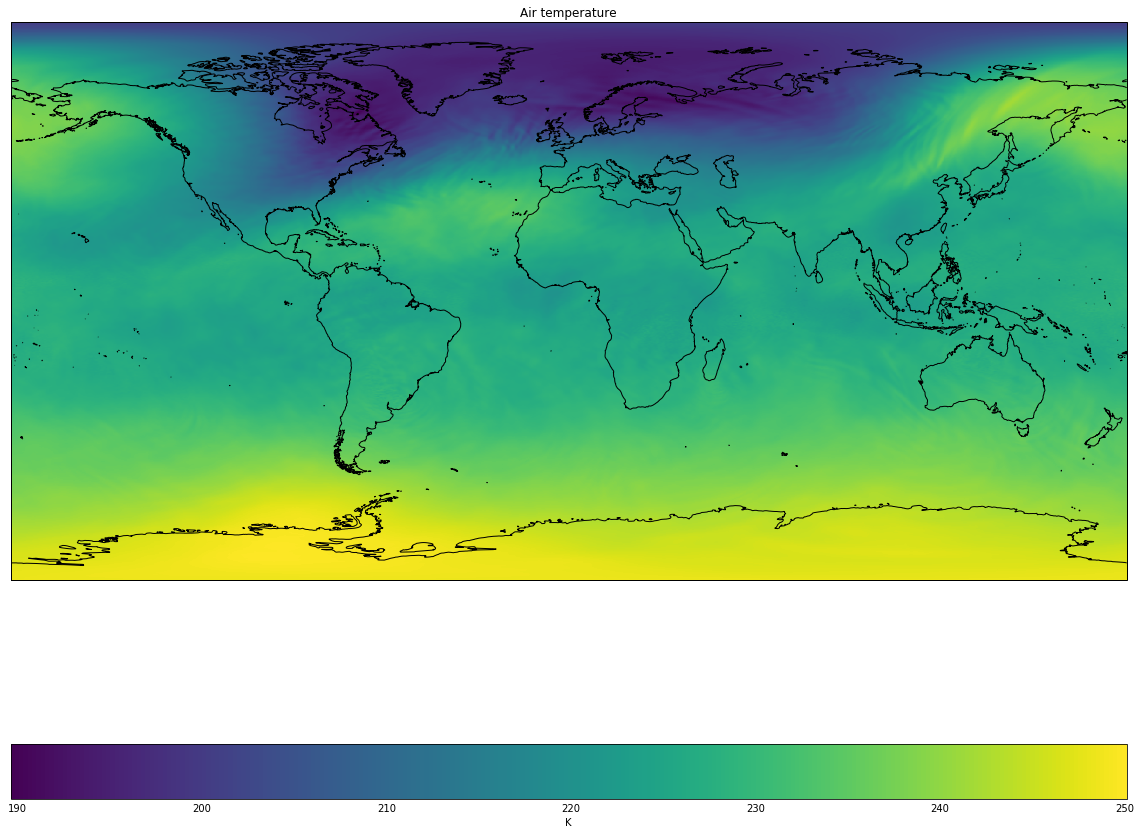

In [59]:
%matplotlib inline

import matplotlib.pyplot as plt
import iris.quickplot as qplt

# Set the size of the plot
plt.figure(figsize=(20, 20))

# iris quickplot sets up our axes and labels so we don't have to
qplt.pcolormesh(air_temp, cmap='viridis')

# Add coastlines
plt.gca().coastlines('50m')

## Finally...

We hope you found this page a useful introduction. 

You can find the Iris reference documentation, a user guide and examples at the [SciTools website]( http://scitools.org.uk/iris/docs/latest/index.html). There's also more information about the Met Office models at on the [Mogreps](http://www.metoffice.gov.uk/research/weather/ensemble-forecasting/mogreps) page.

This data is free to use for research purposes only, and not for profit making applications. Any derived products should acknowledge the use of Met Office data. No ongoing level of support is implied and data may be changed or removed without notice.